In [1]:
import pandas as pd
import numpy as np

In [2]:
from scipy.stats import skew

In [3]:
import matplotlib
import matplotlib.pyplot as plt

In [4]:
import xgboost as xgb

In [5]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
from sklearn import metrics
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.grid_search import GridSearchCV

D:\DevelopKit\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
D:\DevelopKit\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [6]:
train_df = pd.read_csv('../data/original/train.csv', index_col=0)
test_df = pd.read_csv('../data/original/test.csv', index_col=0)

In [7]:
label_df = pd.DataFrame(train_df['y'])

In [8]:
skew(label_df)

array([ 1.20609583])

In [9]:
label_df = np.log1p(label_df)

In [10]:
train_df.drop(['y'], axis=1, inplace=True)

In [11]:
def munge(df):
    all_df = pd.DataFrame(df.values, index=df.index, columns=df.columns, copy=True)
    all_df.drop(['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X8'], axis=1, inplace=True)
    
    
    #删除取值相同的特征
    all_df.drop(['X11', 'X93', 'X107', 'X233', 'X235', 'X268', 'X289', 'X290' ,'X293' ,'X297', 'X330' ,'X347'], axis=1, inplace=True)
    
    #构造新特征
    all_df['parts'] = all_df.sum(axis=1)
    return all_df

In [12]:
munged_train_df = munge(train_df)
munged_test_df = munge(test_df)

In [13]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaler.fit(munged_train_df['parts'])

scaled = scaler.transform(munged_train_df['parts'])
munged_train_df['parts'] = scaled

scaled = scaler.transform(munged_test_df['parts'])
munged_test_df['parts'] = scaled

D:\DevelopKit\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
D:\DevelopKit\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
D:\DevelopKit\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single featur

In [14]:
# Convert categorical features using one-hot encoding.
def onehot(onehot_df, df, column_name, fill_na):
    onehot_df[column_name] = df[column_name]
    if fill_na is not None:
        onehot_df[column_name].fillna(fill_na, inplace=True)

    dummies = pd.get_dummies(onehot_df[column_name], prefix = column_name)
    
    onehot_df = onehot_df.join(dummies)
    onehot_df = onehot_df.drop([column_name], axis=1)
    return onehot_df

def munge_onehot(df):
    onehot_df = pd.DataFrame(index = df.index)

    onehot_df = onehot(onehot_df, df, "X0", None)
    onehot_df = onehot(onehot_df, df, "X1", None)
    onehot_df = onehot(onehot_df, df, "X2", None)
    onehot_df = onehot(onehot_df, df, "X3", None)
    onehot_df = onehot(onehot_df, df, "X4", None)
    onehot_df = onehot(onehot_df, df, "X5", None)
    onehot_df = onehot(onehot_df, df, "X6", None)
    onehot_df = onehot(onehot_df, df, "X8", None)
    
    return onehot_df

In [15]:
onehot_df = munge_onehot(train_df)
munged_train_df = munged_train_df.join(onehot_df)

In [16]:
onehot_df = munge_onehot(test_df)
munged_test_df = munged_test_df.join(onehot_df)

In [17]:
set(munged_test_df) - set(munged_train_df)

{'X0_ae',
 'X0_ag',
 'X0_an',
 'X0_av',
 'X0_bb',
 'X0_p',
 'X2_ab',
 'X2_ad',
 'X2_aj',
 'X2_ax',
 'X2_u',
 'X2_w',
 'X5_a',
 'X5_b',
 'X5_t',
 'X5_z'}

In [18]:
#删除test中有的  而train中没有的
munged_test_df.drop(['X0_ae', 'X0_ag', 'X0_an', 'X0_av', 'X0_bb', 'X0_p',
                     'X2_ab', 'X2_ad', 'X2_aj', 'X2_ax', 'X2_u', 'X2_w', 'X5_a', 'X5_b', 'X5_t', 'X5_z'], axis=1, inplace=True)

In [19]:
set(munged_train_df) - set(munged_test_df)

{'X0_aa',
 'X0_ab',
 'X0_ac',
 'X0_q',
 'X2_aa',
 'X2_ar',
 'X2_c',
 'X2_l',
 'X2_o',
 'X5_u'}

In [20]:
#删除train中有的  而test中没有的
munged_train_df.drop(['X0_aa', 'X0_ab', 'X0_ac', 'X0_q', 'X2_aa', 'X2_ar', 'X2_c', 'X2_l', 'X2_o', 'X5_u'], axis=1, inplace=True)

In [21]:
#删除一些占比非常不平衡的特征

In [22]:
munged_train_df['X10'].value_counts()[0]

4153

In [23]:
s = munged_train_df.shape[0]
drop_names = []
for c in munged_train_df.drop(['parts'], axis=1).columns:
    a = munged_train_df[c].value_counts()[0] / s
    b = munged_train_df[c].value_counts()[1] / s
    if (a < 0.05 or b < 0.05):
        print('%s p1 = %f p2 = %f'%(c, a, b))
        drop_names.append(c)

X10 p1 = 0.986695 p2 = 0.013305
X15 p1 = 0.999525 p2 = 0.000475
X16 p1 = 0.997387 p2 = 0.002613
X17 p1 = 0.992397 p2 = 0.007603
X18 p1 = 0.992160 p2 = 0.007840
X21 p1 = 0.997387 p2 = 0.002613
X23 p1 = 0.979330 p2 = 0.020670
X24 p1 = 0.998099 p2 = 0.001901
X26 p1 = 0.995011 p2 = 0.004989
X28 p1 = 0.967451 p2 = 0.032549
X29 p1 = 0.956997 p2 = 0.043003
X30 p1 = 0.995486 p2 = 0.004514
X32 p1 = 0.988833 p2 = 0.011167
X33 p1 = 0.999762 p2 = 0.000238
X34 p1 = 0.994536 p2 = 0.005464
X36 p1 = 0.995486 p2 = 0.004514
X38 p1 = 0.966738 p2 = 0.033262
X39 p1 = 0.999762 p2 = 0.000238
X40 p1 = 0.999287 p2 = 0.000713
X41 p1 = 0.988596 p2 = 0.011404
X42 p1 = 0.999762 p2 = 0.000238
X44 p1 = 0.988596 p2 = 0.011404
X47 p1 = 0.987170 p2 = 0.012830
X48 p1 = 0.977667 p2 = 0.022333
X52 p1 = 0.957710 p2 = 0.042290
X53 p1 = 0.993110 p2 = 0.006890
X54 p1 = 0.956522 p2 = 0.043478
X55 p1 = 0.994773 p2 = 0.005227
X56 p1 = 0.978855 p2 = 0.021145
X57 p1 = 0.986695 p2 = 0.013305
X59 p1 = 0.999287 p2 = 0.000713
X60 p1 =

In [24]:
len(drop_names)

373

In [25]:
munged_train_df.drop(drop_names, axis=1, inplace=True)
munged_test_df.drop(drop_names, axis=1, inplace=True)

In [26]:
from sklearn.decomposition import PCA, FastICA

In [27]:
#PCA

In [28]:
n_comp = 10

pca = PCA(n_components=n_comp, random_state=42)
pca2_results_train = pca.fit_transform(munged_train_df)
pca2_results_test = pca.transform(munged_test_df)

In [29]:
#ICA
ica = FastICA(n_components=n_comp, random_state=42)
ica2_results_train = ica.fit_transform(munged_train_df)
ica2_results_test = ica.transform(munged_test_df)

In [30]:
# Append decomposition components to datasets
for i in range(1, n_comp+1):
    munged_train_df['pca_' + str(i)] = pca2_results_train[:,i-1]
    munged_test_df['pca_' + str(i)] = pca2_results_test[:, i-1]
    
    munged_train_df['ica_' + str(i)] = ica2_results_train[:,i-1]
    munged_test_df['ica_' + str(i)] = ica2_results_test[:, i-1]

In [31]:
munged_train_df.to_csv('../data/offline/train.csv')
munged_test_df.to_csv('../data/offline/test.csv')
label_df.to_csv('../data/offline/y_train.csv')

In [46]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [47]:
def modelfit(alg, feature_names, X_train, y_train, X_test, y_test, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X_train, label=y_train)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='rmse', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])

    #Fit the algorithm on the data
    alg.fit(X_train, y_train)

    #Predict training set:
    y_predictions = alg.predict(X_test)
#     dtrain_predprob = alg.predict_proba(y_test)

    #Print model report:
    print("\nModel Report")
    print("RMSE : %.4g" % metrics.mean_squared_error(y_test, y_predictions))
    #print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Disbursed'], dtrain_predprob))

    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp = feat_imp.rename(lambda x: feature_names[int(x[1:len(x)])])
    
    feat_imp.plot(kind='barh', title='Feature Importances',figsize=(7, 16))
    plt.ylabel('Feature Importance Score')

In [48]:
def ModelParamSearch(xgb, params, X_train, y_train):
    search = GridSearchCV(estimator=xgb, param_grid=params, n_jobs=4, iid=False, cv=5)
    search.fit(X_train, y_train)
    print('\ngrid_scores')
    for score in search.grid_scores_:
        print(score)
    print('\nbest_params')
    print(search.best_params_)
    print('\nbest_score')
    print(search.best_score_)
    return search

In [49]:
xgb_model = xgb.XGBRegressor(max_depth=2, learning_rate=0.1, n_estimators=100,\
                             silent=False, objective='reg:linear', subsample=0.8,\
                             colsample_bytree=0.75, gamma=0, min_child_weight = 6,\
                             scale_pos_weight=1, seed=27)

params1 = {
 'max_depth':np.array(range(3, 6, 1)),
 'min_child_weight':np.array(range(1,6, 1)),
}

search1 = ModelParamSearch(xgb_model, params1, X_train, y_train)


grid_scores
mean: 0.63236, std: 0.02830, params: {'min_child_weight': 1, 'max_depth': 3}
mean: 0.63283, std: 0.02815, params: {'min_child_weight': 2, 'max_depth': 3}
mean: 0.63376, std: 0.03011, params: {'min_child_weight': 3, 'max_depth': 3}
mean: 0.63394, std: 0.02881, params: {'min_child_weight': 4, 'max_depth': 3}
mean: 0.63539, std: 0.03031, params: {'min_child_weight': 5, 'max_depth': 3}
mean: 0.62739, std: 0.03049, params: {'min_child_weight': 1, 'max_depth': 4}
mean: 0.62823, std: 0.02963, params: {'min_child_weight': 2, 'max_depth': 4}
mean: 0.63081, std: 0.02900, params: {'min_child_weight': 3, 'max_depth': 4}
mean: 0.63020, std: 0.03016, params: {'min_child_weight': 4, 'max_depth': 4}
mean: 0.63164, std: 0.03068, params: {'min_child_weight': 5, 'max_depth': 4}
mean: 0.62150, std: 0.02654, params: {'min_child_weight': 1, 'max_depth': 5}
mean: 0.62029, std: 0.02536, params: {'min_child_weight': 2, 'max_depth': 5}
mean: 0.61927, std: 0.02950, params: {'min_child_weight': 3, 'm

In [51]:
xgb_model = xgb.XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=100,\
                             silent=False, objective='reg:linear', subsample=0.8,\
                             colsample_bytree=0.75, gamma=0, min_child_weight = 5,\
                             scale_pos_weight=1, seed=27)

params2 = {
 'subsample':[i/100.0 for i in range(50, 90, 5)],
 'colsample_bytree':[i/100.0 for i in range(50, 90, 5)]
}

search2 = ModelParamSearch(xgb_model, params2, X_train, y_train)


grid_scores
mean: 0.62739, std: 0.02856, params: {'subsample': 0.5, 'colsample_bytree': 0.5}
mean: 0.63243, std: 0.02958, params: {'subsample': 0.55, 'colsample_bytree': 0.5}
mean: 0.63026, std: 0.02627, params: {'subsample': 0.6, 'colsample_bytree': 0.5}
mean: 0.63127, std: 0.02678, params: {'subsample': 0.65, 'colsample_bytree': 0.5}
mean: 0.63266, std: 0.02885, params: {'subsample': 0.7, 'colsample_bytree': 0.5}
mean: 0.63125, std: 0.02808, params: {'subsample': 0.75, 'colsample_bytree': 0.5}
mean: 0.63394, std: 0.02911, params: {'subsample': 0.8, 'colsample_bytree': 0.5}
mean: 0.63513, std: 0.03226, params: {'subsample': 0.85, 'colsample_bytree': 0.5}
mean: 0.62925, std: 0.03003, params: {'subsample': 0.5, 'colsample_bytree': 0.55}
mean: 0.63195, std: 0.03029, params: {'subsample': 0.55, 'colsample_bytree': 0.55}
mean: 0.62982, std: 0.02469, params: {'subsample': 0.6, 'colsample_bytree': 0.55}
mean: 0.63106, std: 0.02893, params: {'subsample': 0.65, 'colsample_bytree': 0.55}
mean:

In [54]:
xgb_model = xgb.XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=100,\
                             silent=False, objective='reg:linear', subsample=0.85,\
                             colsample_bytree=0.8, gamma=0, min_child_weight = 5,\
                             scale_pos_weight=1, seed=27)

params3 = {
 'learning_rate':[0.01, 0.03, 0.05],
 'n_estimators':[100, 1000, 3000],
}

search3 = ModelParamSearch(xgb_model, params3, X_train, y_train)


grid_scores
mean: -163.28237, std: 13.77925, params: {'learning_rate': 0.01, 'n_estimators': 100}
mean: 0.63871, std: 0.02933, params: {'learning_rate': 0.01, 'n_estimators': 1000}
mean: 0.62039, std: 0.03020, params: {'learning_rate': 0.01, 'n_estimators': 3000}
mean: -2.15770, std: 0.13825, params: {'learning_rate': 0.03, 'n_estimators': 100}
mean: 0.61970, std: 0.03006, params: {'learning_rate': 0.03, 'n_estimators': 1000}
mean: 0.57926, std: 0.02264, params: {'learning_rate': 0.03, 'n_estimators': 3000}
mean: 0.59756, std: 0.04145, params: {'learning_rate': 0.05, 'n_estimators': 100}
mean: 0.60160, std: 0.02977, params: {'learning_rate': 0.05, 'n_estimators': 1000}
mean: 0.55400, std: 0.02297, params: {'learning_rate': 0.05, 'n_estimators': 3000}

best_params
{'learning_rate': 0.01, 'n_estimators': 1000}

best_score
0.6387061470047611


In [55]:
xgb_model = xgb.XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=100,\
                             silent=False, objective='reg:linear', subsample=0.85,\
                             colsample_bytree=0.8, gamma=0, min_child_weight = 5,\
                             scale_pos_weight=1, seed=27)

param4 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

search4 = ModelParamSearch(xgb_model, param4, X_train, y_train)


grid_scores
mean: 0.64027, std: 0.03093, params: {'reg_alpha': 1e-05}
mean: 0.63981, std: 0.03060, params: {'reg_alpha': 0.01}
mean: 0.63928, std: 0.03134, params: {'reg_alpha': 0.1}
mean: 0.63922, std: 0.02877, params: {'reg_alpha': 1}
mean: -0.28445, std: 0.07618, params: {'reg_alpha': 100}

best_params
{'reg_alpha': 1e-05}

best_score
0.6402732273341691


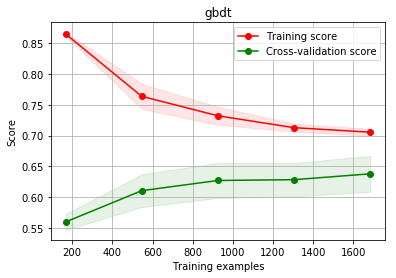

In [56]:
#gamma=0, min_child_weight=1, max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5, seed=0, missing=Nonemax_depth=3, learning_rate=0.1, n_estimators=100, silent=True, objective='reg:linear', booster='gbtree', nthread=-1, gamma=0, min_child_weight=1, max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5, seed=0, missing=None
regr = xgb.XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=100,\
                        silent=False, objective='reg:linear', subsample=0.85,\
                        colsample_bytree=0.7, gamma=0, min_child_weight = 5,\
                        scale_pos_weight=1, seed=27, reg_alpha=1e-05)

plot_learning_curve(regr, 'gbdt', X_train, y_train, cv=5)
plt.show()

In [57]:
regr.fit(X_train, y_train)
regr.score(X_test, y_test)

0.59088722316855979

In [58]:
regr.fit(munged_train_df.values, label_df.values)

# Run prediction on training set to get a rough idea of how well it does.
# y_pred = regr.predict(munged_train_df.values)
# y_test = label_df
# print("XGBoost score on training set: ", rmse(y_test, y_pred))

# Run prediction on the Kaggle test set.
y_pred_xgb = regr.predict(munged_test_df.values)

In [41]:
from sklearn.linear_model import Lasso

# I found this best alpha through cross-validation.
best_alpha = 0.00099

regr = Lasso(alpha=best_alpha, max_iter=50000)
regr.fit(munged_train_df, label_df)

# Run prediction on training set to get a rough idea of how well it does.
y_pred = regr.predict(munged_train_df)
y_test = label_df
#print("Lasso score on training set: ", rmse(y_test, y_pred))

# Run prediction on the Kaggle test set.
y_pred_lasso = regr.predict(munged_test_df)

In [59]:
#y_pred = (y_pred_xgb + y_pred_lasso) / 2
y_pred = y_pred_xgb
y_pred = np.expm1(y_pred)

pred_df = pd.DataFrame(y_pred, index=test_df.index, columns=["y"])
pred_df.to_csv('output.csv', header=True, index_label='Id')